# Multi-Class Image Classification for Oxford-IIIT Pets dataset

___
### Objectives:
* Perform data preprocessing and EDA on pets dataset
* Implement classification using **ResNet50_V2**, **MobileNet_V2**, and **Inception_V3**
* Evaluate on the performance and some analysis

___
### Dataset Info:
- Oxford-IIIT dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/)
- The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.

___
### Import necessary library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI Project')

In [3]:
%pip install tensorflow_datasets==4.9.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.7
    Uninstalling tensorflow-datasets-4.9.7:
      Successfully uninstalled tensorflow-datasets-4.9.7


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import callbacks
from keras import layers, models

### Data Preprocessing + Exploratory Data Analysis

#### Load and split the raw image data

In [12]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:80%]',
                                                          'train[80%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

In [14]:
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 2944
Number of validation samples: 736
Number of test samples: 3669


,image,label
0,,33 (Sphynx)
1,,6 (Birman)
2,,13 (english_setter)
3,,12 (english_cocker_spaniel)
4,,12 (english_cocker_spaniel)

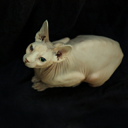
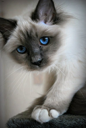
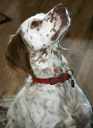
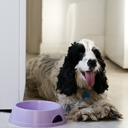
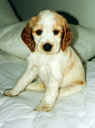

In [15]:
# Display several examples of the training set
examples = tfds.as_dataframe(train_raw.take(5), ds_info)
examples

In [16]:
# Get number of classes
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)

Number of classes: 37


In [17]:
ds_info.features['label'].names

['Abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'boxer',
 'British_Shorthair',
 'chihuahua',
 'Egyptian_Mau',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'Maine_Coon',
 'miniature_pinscher',
 'newfoundland',
 'Persian',
 'pomeranian',
 'pug',
 'Ragdoll',
 'Russian_Blue',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'Siamese',
 'Sphynx',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [18]:
ds_info.features['species'].names

['Cat', 'Dog']

In [28]:
# Extract species names
species_names = ds_info.features['species'].names
species_list = []

# Iterate over the train dataset to populate the list with species information
for image, label in train_raw:  # Unpack the tuple into image and label
    # Access species using ds_info.features to get the species for the label
    species_index = ds_info.features['label'].str2int(get_label_name(label))  # Get species index from label
    species = species_names[species_index % 2]  # Map to species_names (assuming species is cat or dog based on label)
    species_list.append(species)

species_counts = pd.Series(species_list).value_counts(sort=True)
species_counts.index = species_counts.index.map(lambda x: x)  # No need to map again

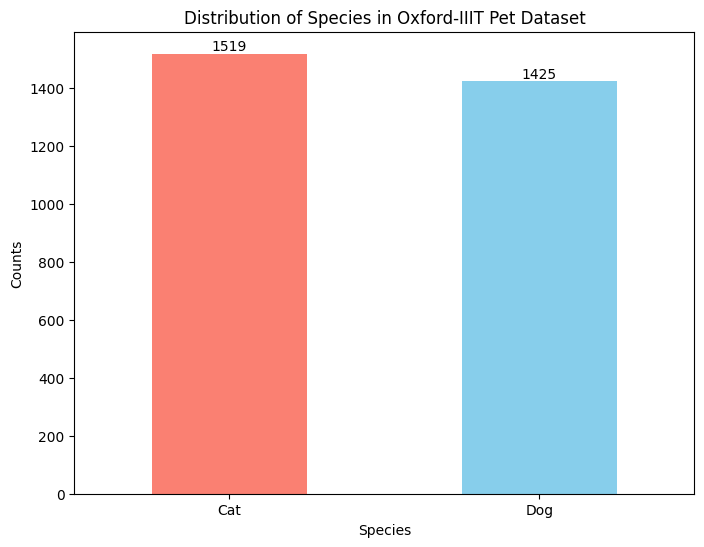

In [29]:
# Plotting the distribution of species with count number on each bar
plt.figure(figsize=(8, 6))
bar_plot = species_counts.plot(kind='bar', color=['salmon', 'skyblue'])

plt.xlabel('Species')
plt.ylabel('Counts')
plt.title('Distribution of Species in Oxford-IIIT Pet Dataset')

# Add count number on each bar
for i, count in enumerate(species_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.xticks(rotation=0)
plt.show()

In [20]:
def get_value_counts(ds, ds_info):
    label_names = ds_info.features['label'].names
    label_list = []

    for example in ds:
        label = example['label'].numpy()
        label_list.append(label)

    label_counts = pd.Series(label_list).value_counts(sort=True)
    label_counts.index = label_counts.index.map(lambda x: label_names[x])

    return label_counts

In [21]:
def get_value_counts(ds, ds_info):
    label_names = ds_info.features['label'].names
    label_list = []

    for image, label in ds:  # Unpack the tuple into image and label
        label_list.append(label.numpy())  # Access label directly and convert to NumPy

    label_counts = pd.Series(label_list).value_counts(sort=True)
    label_counts.index = label_counts.index.map(lambda x: label_names[x])

    return label_counts

In [22]:
get_value_counts(train_raw, ds_info)

,count
american_pit_bull_terrier,87
Ragdoll,86
leonberger,86
yorkshire_terrier,86
english_setter,85
wheaten_terrier,84
keeshond,83
beagle,83
Maine_Coon,83
miniature_pinscher,82


In [23]:
# Build the custom function to display image and label name
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

In [24]:
# Function to obtain the name for the label integer
get_label_name = ds_info.features['label'].int2str

Image shape:  (500, 334, 3)


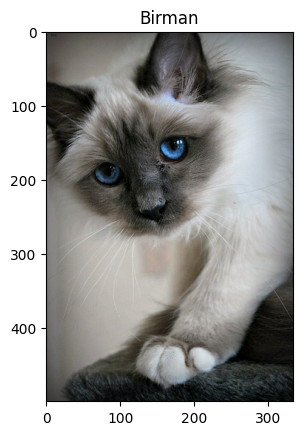

In [25]:
view_single_image(train_raw)

In [26]:
# Function to get the height and width of images from a dataset
def get_image_dimensions(dataset):
    heights = []
    widths = []
    for image, label in dataset:
        heights.append(image.shape[0])
        widths.append(image.shape[1])
    return heights, widths

# Collect heights and widths from train, validation, and test datasets
train_heights, train_widths = get_image_dimensions(train_raw)
val_heights, val_widths = get_image_dimensions(val_raw)
test_heights, test_widths = get_image_dimensions(test_raw)

# Combine all heights and widths
all_heights = train_heights + val_heights + test_heights
all_widths = train_widths + val_widths + test_widths

# Count the frequency of each height and width
height_counter = Counter(all_heights)
width_counter = Counter(all_widths)

# Separate keys and values for plotting
heights, height_counts = zip(*height_counter.items())
widths, width_counts = zip(*width_counter.items())

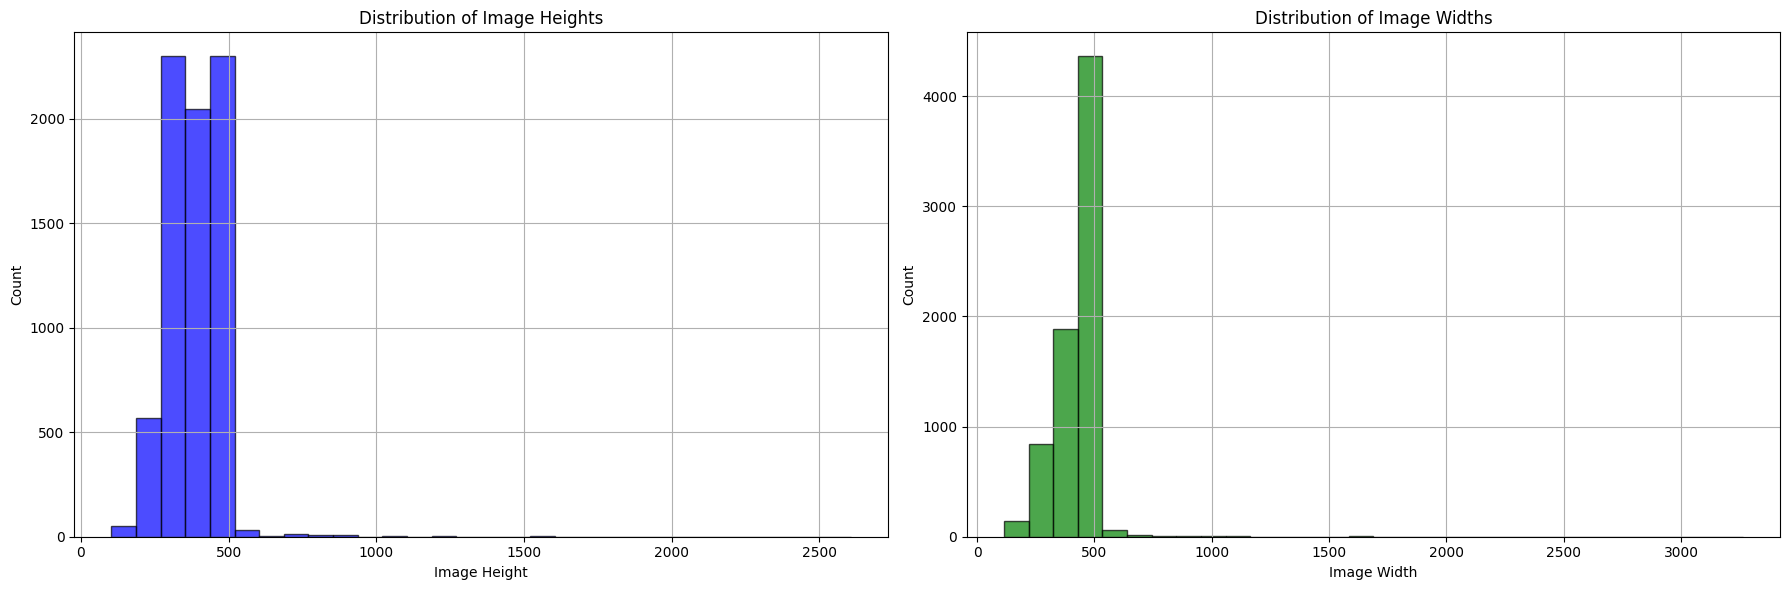

In [27]:
# Plot the distributions side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram for heights
axes[0].hist(all_heights, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Image Height')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Image Heights')
axes[0].grid(True)

# Plot the histogram for widths
axes[1].hist(all_widths, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Image Width')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Image Widths')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### (i) Image Resizing
- Because the raw images come in different sizes, we want to resize them to the same size before parsing them into the neural network later
- More specifically, we want both the length and width to be 224 pixels (which is what ResNet50_V2 expects)

In [30]:
IMG_SIZE = 224

# Resize images
def resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds = train_raw.map(resize)
val_ds = val_raw.map(resize)
test_ds = test_raw.map(resize)

In [31]:
# View the shape of data after transformation
train_ds.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

___
### (ii) Label One-hot Encoding
- There are 37 classes (i.e. pet breeds) in the dataset that we are using for multi-class image classification
- As such, we proceed to one-hot encode the labels so that we get a output vector of length 37

In [32]:
# Encoding the target label
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [33]:
num_classes = 37

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [34]:
for value in train_ds.take(1):
    print(value)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 4.4686704 ,  3.        ,  3.1430166 ],
        [ 5.3134565 ,  3.3134565 ,  4.3134565 ],
        [ 6.780054  ,  4.061703  ,  4.851482  ],
        ...,
        [ 0.727274  ,  0.727274  ,  0.16070557],
        [ 4.848214  ,  1.6160715 ,  2.6160715 ],
        [ 5.7008214 ,  2.4686785 ,  3.4686785 ]],

       [[ 5.464286  ,  4.464286  ,  2.4642859 ],
        [ 5.976961  ,  5.544643  ,  4.        ],
        [ 5.9074454 ,  5.7556596 ,  3.7556596 ],
        ...,
        [ 3.6437452 ,  3.6437452 ,  1.8044508 ],
        [ 5.3035803 ,  1.30358   ,  0.30358005],
        [ 7.4774504 ,  3.4774504 ,  2.4774504 ]],

       [[ 4.776787  ,  4.42371   ,  2.584425  ],
        [ 0.6720352 ,  2.3928583 ,  0.33689496],
        [ 2.3953304 ,  2.3953304 ,  2.408245  ],
        ...,
        [ 1.9390181 ,  1.9390181 ,  0.01291391],
        [ 2.0121977 ,  2.0121977 ,  2.1729128 ],
        [ 3.950495  ,  3.950495  ,  4.1112103 ]],

       ...,

    

From the printout, we can see that each dataset object (i.e., `train_ds`, `val_ds`, and `test_ds`) has two components each:
- Images of shape (224,224,3)
- Label vector of shape (37,)

The values in each component has also been casted to a float data type, which is what we want for the deep learning model later.

### (iii) Data Augmentation
- Create training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.
- The purpose is to reduce model overfitting by exposing our model to variations and small transformations in the original data. It is useful especially when we do not have a large dataset.
- To perform data augmentation, we use the Keras preprocessing layers API. Each type of image augmentation that we want to introduce is defined as a layer within a Keras Sequential class.

In [35]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

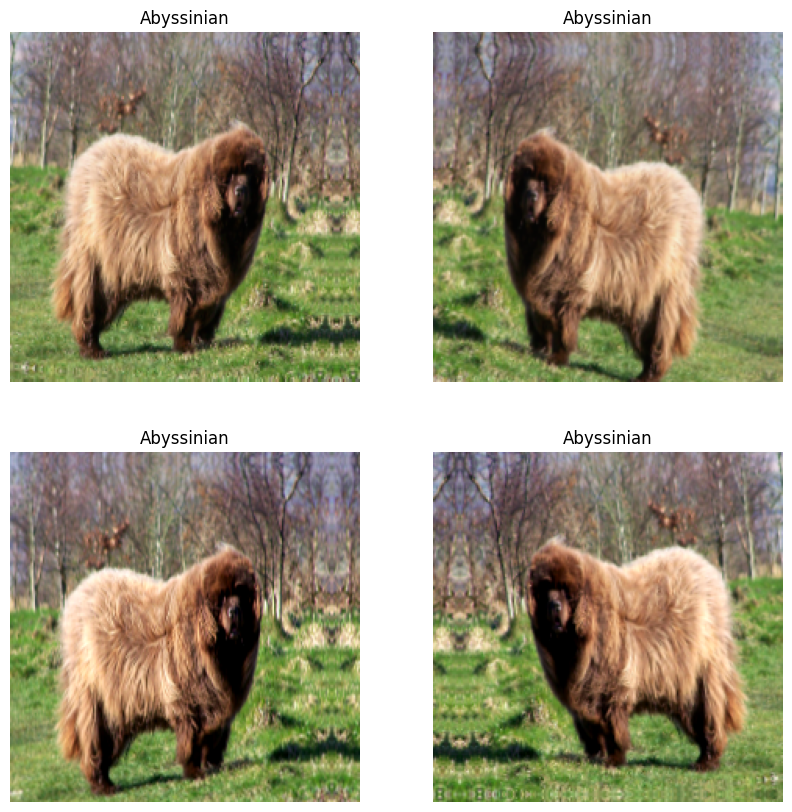

In [36]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

### (iv) Batching and Prefetching
- Batch the data and use prefetching to optimize loading speed and model efficiency
- The number of elements to prefetch can be automatically determined by making use of `tf.data.AUTOTUNE`, which prompt the runtime to tune the value dynamically for us.

In [37]:
BATCH_SIZE = 32

In [38]:
# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds = train_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

- Caching (with `.cache()`) is another way to speed up the process, where we store dataset either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

___
## (5) Model Setup
- With the data prepared, it is time to define the model we want to use for the multi-class classification task
- For this task, we will make use of transfer learning so that we do not need to train a deep learning model from scratch (which is tedious and requires plenty of data)
- Keras comes with a host of pre-trained models that we can leverage for transfer learning: https://keras.io/api/applications/
- We will be using ResNet50V2 given that it offers a good balance of accuracy, size, and speed

### (i) Setup base model
- Instantiate a ResNet50V2 object from `keras.applications`
- Set `include_top=False` because we want to remove the top layers of the pre-trained model (that was trained to classify ImageNet) and introduce our own final layers for our specific car image classification task
- Keep the weights as `imagenet`, because we want to keep the ResNet weights that were trained on the ImageNet dataset
- This process is known as transfer learning, because we use the pre-trained ImageNet weights

In [39]:
IMG_SIZE = 224

base_model = keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### (ii) Freeze pre-trained weights of the base model
- When a trainable weight becomes non-trainable, its value is no longer updated during training.

In [40]:
# Freeze the base_model
base_model.trainable = False

### (iii) Modify inputs


In [41]:
# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

In [42]:
x = keras.applications.resnet_v2.preprocess_input(x)

In [43]:
x = base_model(x, training=False)

In [44]:
x.shape

(None, 7, 7, 2048)

- Although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model.
- This means that the batch normalization layers inside will not update their batch statistics (i.e., mean and variance)
- If they did, they would wreak havoc on the representations learned by the model so far because the training done would have been undone.

### (iv) Rebuild top layers
- Given that we have removed the top ImageNet classifier layer of ResNet50V2, we can now build a custom top layer that is specific to our image classification task i.e., classify an image based on the 37 different pet breeds types.

In [45]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)

#### Display model summary

In [46]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 37)                  │          75,813 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,648,805 (90.21 MB)

 Trainable params: 79,909 (312.14 KB)

 Non-trainable params: 23,568,896 (89.91 MB)

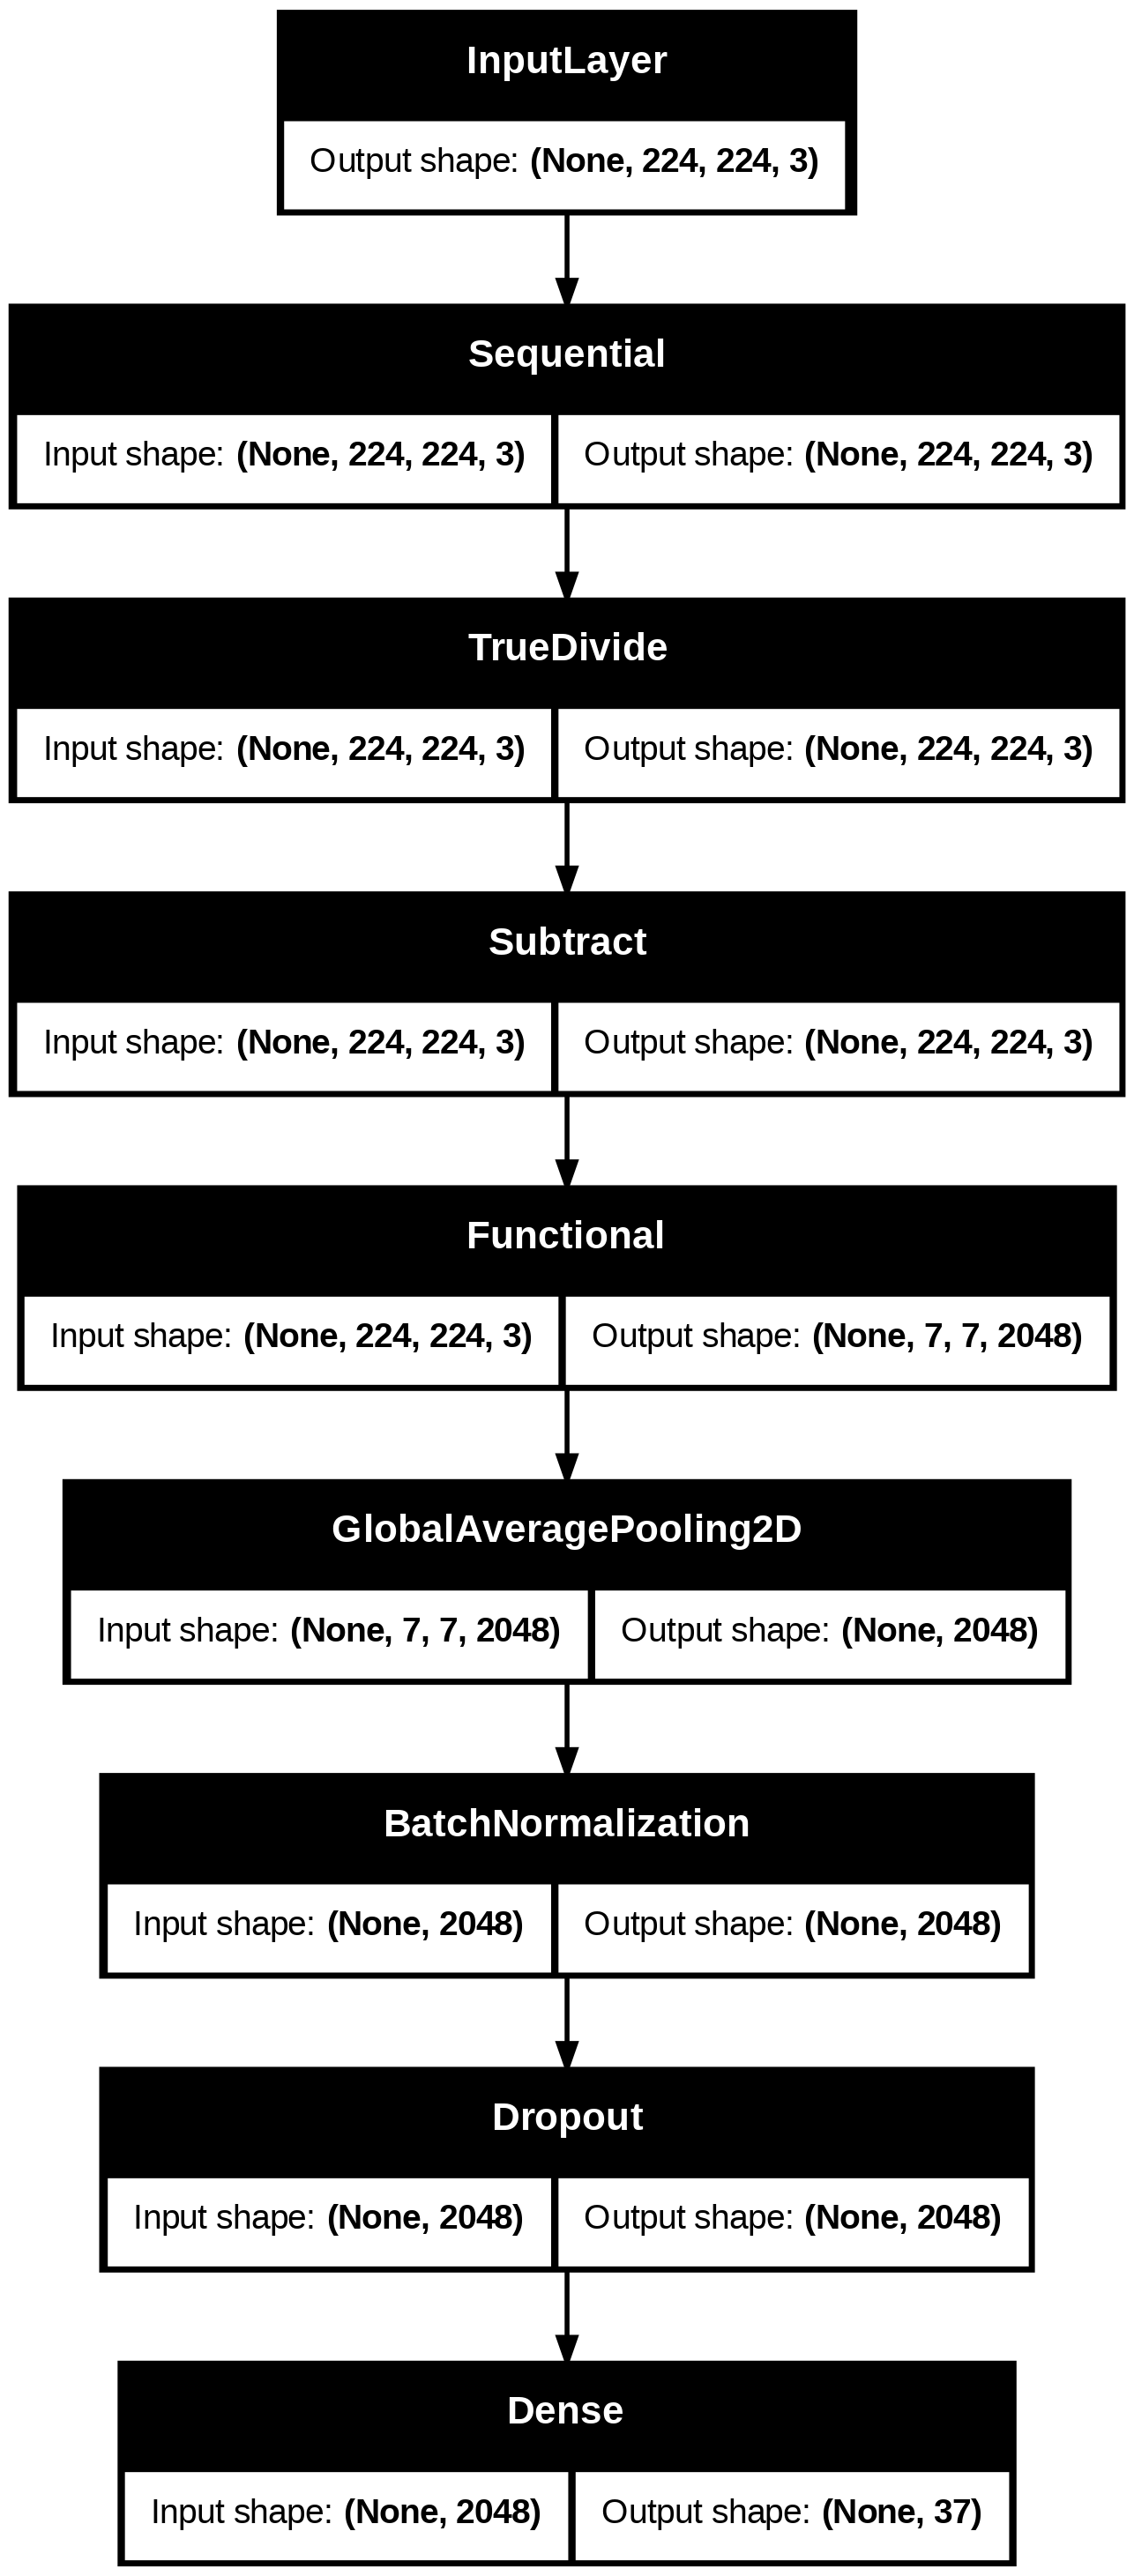

In [47]:
keras.utils.plot_model(model, show_shapes=True)

#### Compile model
- Utilize the commonly used Adam optimizer (leave the learning rate as default)
- Since it is a multi-class classification, we will use categorical cross entropy and categorical accuracy as our loss and performance metric respectively

In [48]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Include early stopping
- Prevent overfitting

In [49]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

___
## (6) Model Training

#### Fit model
- Ensure that the Google Colab runtime using GPU hardware accelerator
- Fit the model over the training dataset for 15 epochs
- Store the training output as a variable called `history`

In [50]:
EPOCHS = 15

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - categorical_accuracy: 0.4173 - loss: 2.2716 - val_categorical_accuracy: 0.8465 - val_loss: 0.5911
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - categorical_accuracy: 0.8653 - loss: 0.4261 - val_categorical_accuracy: 0.8573 - val_loss: 0.4523
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - categorical_accuracy: 0.9199 - loss: 0.2685 - val_categorical_accuracy: 0.8723 - val_loss: 0.4070
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - categorical_accuracy: 0.9295 - loss: 0.2100 - val_categorical_accuracy: 0.8696 - val_loss: 0.3935
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - categorical_accuracy: 0.9494 - loss: 0.1654 - val_categorical_accuracy: 0.8764 - val_loss: 0.3948
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - categorical_accuracy: 0.9529 - loss: 0.1473 - val_categorical_accuracy: 0.8791 - val_loss: 0.3851
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - categorical_accuracy: 0.964

In [52]:
model.save("Models/ResNet50_V2.keras")

#### Plot the accuracy of training and validation sets over epochs

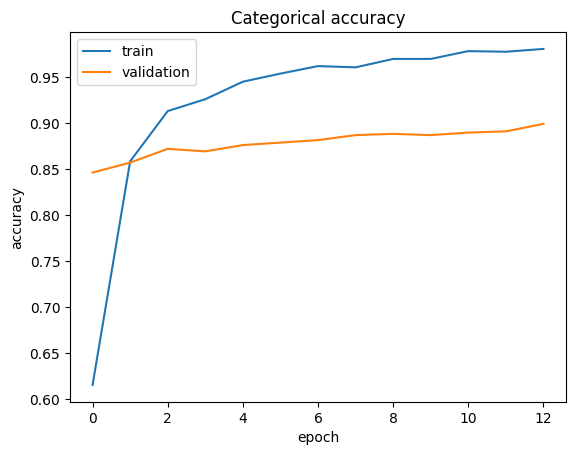

In [53]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

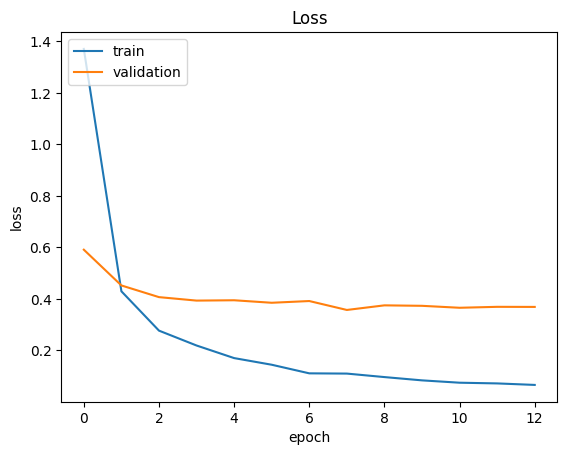

In [54]:
def plot_hist(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

___
## (7) Model Evaluation

In [55]:
model = keras.models.load_model('Models/ResNet50_V2.keras')

In [56]:
preds = model.predict(test_ds)

114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step


#### Evaluate model on test dataset

In [57]:
result = model.evaluate(test_ds)

114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - categorical_accuracy: 0.8728 - loss: 0.4484


#### Display results

In [58]:
dict(zip(model.metrics_names, result))

{'loss': 0.4558561444282532, 'compile_metrics': 0.8667762875556946}

___
## (8) Finetune Model
- Once our model has converged on the new data, we can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate (e.g., 0.0001)
- This is an optional last step that can potentially give us incremental improvements. However, it can also potentially lead to quick overfitting.

#### Unfreeze base model
- We only want to unfreeze top 15 layers that are NOT batch normalization layers

In [59]:
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

#### Recompile model
- This step needs to be done to take into account the change above, where we set the `trainable` attribute of the base model layers to True

In [60]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Set a very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Retrain model
- Using fewer epochs given the high risk of overfitting in fine-tuning

In [61]:
EPOCHS = 5

history_2 = model.fit(train_ds,
                      epochs=EPOCHS,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks =[earlystopping])

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 455ms/step - categorical_accuracy: 0.8518 - loss: 0.4603 - val_categorical_accuracy: 0.8764 - val_loss: 0.3863
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - categorical_accuracy: 0.9238 - loss: 0.2536 - val_categorical_accuracy: 0.8723 - val_loss: 0.4131
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - categorical_accuracy: 0.9452 - loss: 0.1714 - val_categorical_accuracy: 0.8777 - val_loss: 0.4253
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - categorical_accuracy: 0.9597 - loss: 0.1397 - val_categorical_accuracy: 0.8723 - val_loss: 0.4372
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - categorical_accuracy: 0.9677 - loss: 0.1215 - val_categorical_accuracy: 0.8696 - val_loss: 0.4247


#### Display fine-tuned model results

In [62]:
result_2 = model.evaluate(test_ds)

dict(zip(model.metrics_names, result_2))

114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - categorical_accuracy: 0.8570 - loss: 0.4894


{'loss': 0.4962013065814972, 'compile_metrics': 0.8555372953414917}

We can see that the final step of unfreezing several layers of the model has indeed given the model performance a good boost.

## (9) Run Inference on new data

In [63]:
from keras.preprocessing import image

# Load the saved model
loaded_model = keras.models.load_model("Models/ResNet50_V2.keras")
# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    plt.imshow(img_array/255)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    return img_array

# Function to make predictions
def predict_image(img_array):
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the class with highest probability
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index: 29
Predicted class: samoyed


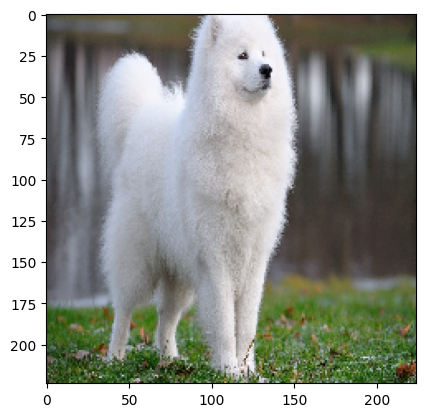

In [64]:
uploaded_file_path = "Samples/samoyed.jpg"

# Preprocess the uploaded image
preprocessed_img = preprocess_image(uploaded_file_path)

class_names = ds_info.features['label'].names

# Make predictions
predicted_class = predict_image(preprocessed_img)

# Display the prediction
print("Predicted class index:", predicted_class)

# Function to map class index to class name
def get_class_name(class_index):
    return class_names[class_index]

# Example usage:
predicted_class_name = get_class_name(predicted_class)

# Print the actual name of the predicted class
print("Predicted class:", predicted_class_name)

## (10) Classification Report

In [65]:
from sklearn.metrics import classification_report, confusion_matrix

In [66]:
# Assuming 'model' is your trained model and 'test_ds' is your test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = loaded_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.81      0.77      0.79        97
          american_bulldog       0.75      0.80      0.78       100
 american_pit_bull_terrier       0.77      0.48      0.60        99
              basset_hound       0.90      0.96      0.93       100
                    beagle       0.89      0.85      0.87        99
                    Bengal       0.71      0.84      0.77       100
                    Birman       0.75      0.64      0.69       100
                    Bombay       0.94      0.89      0.91        88
                     boxer       0.84      0.85      0.84        98
         British_Shorthair       0.74      0.83      0.78       100
                 chihuahua       0.89      0.84      0.87       100
              Egyptian_Mau       0.89      0.77      0.83        96
    english_cocker_spaniel       0.95      0.91      0.93       100
            english_set

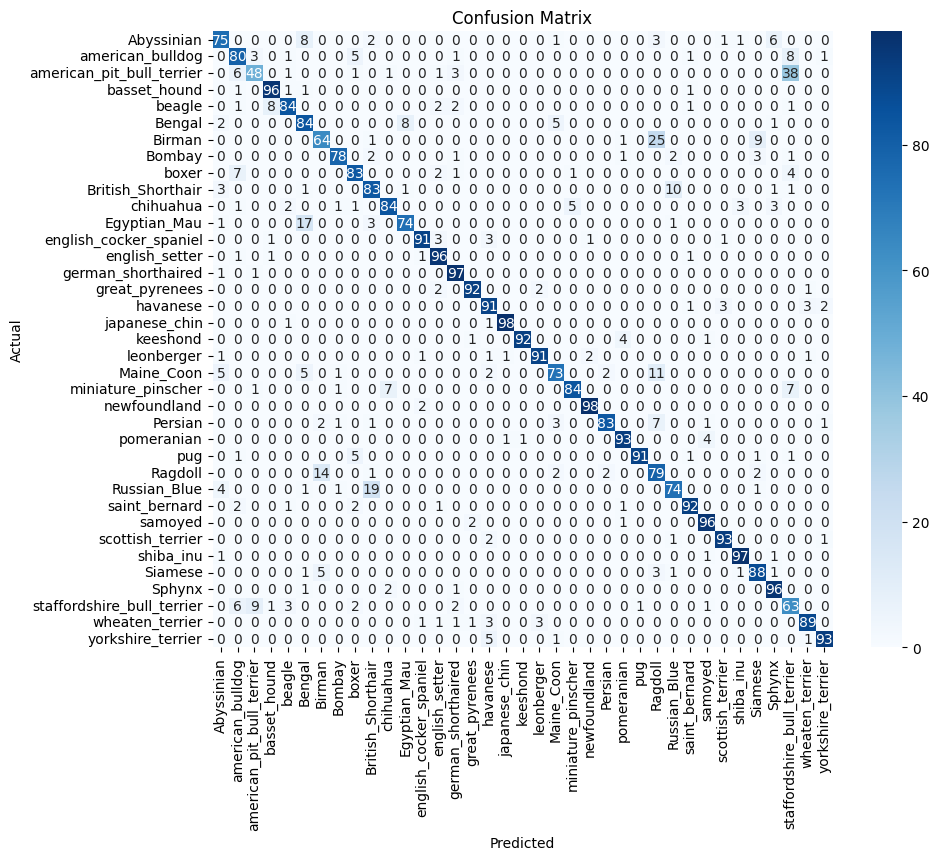

In [67]:
import seaborn as sns
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
class_names = ds_info.features['label'].names  # Ensure this list is available or manually define it
class_report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [73]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score

# Assuming y_true are the true labels/values and y_pred are the predicted labels/values
accuracy = accuracy_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False returns RMSE
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("MAE:", mae)
print("RMSE:", rmse)
print("F1", f1)

Accuracy: 0.8670504385964912
MAE: 2.088815789473684
RMSE: 6.830698572068316
F1 0.8673960506724784


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
